# Challenge: Backtest on Other Datasets

## Download data from `yfinance`

In [ ]:
#pip uninstall bokeh
#pip install bokeh
#pip install bokeh==2.4.3

In [25]:
#import pickle  # Import the pickle module to load the serialized model
import pandas as pd  # Import pandas for data manipulation and analysis
from backtesting import Backtest, Strategy  # Import Backtest and Strategy from the backtesting library
#import pyplot 

In [26]:
#import pkg_resources
#pkg_resources.require("bokeh==2.4.3")
import bokeh
print(bokeh.__version__)


3.6.0


In [27]:
import yfinance as yf
print(yf.__version__)

ticker = 'INTC'
df = yf.download(ticker)
df

0.2.44


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-03-17,0.325521,0.330729,0.325521,0.325521,0.181500,10924800
1980-03-18,0.325521,0.328125,0.322917,0.322917,0.180048,17068800
1980-03-19,0.330729,0.335938,0.330729,0.330729,0.184404,18508800
1980-03-20,0.330729,0.334635,0.329427,0.329427,0.183678,11174400
1980-03-21,0.322917,0.322917,0.317708,0.317708,0.177143,12172800
...,...,...,...,...,...,...
2024-09-27,24.160000,24.660000,23.700001,23.910000,23.910000,85883300
2024-09-30,23.740000,23.950001,23.090000,23.459999,23.459999,66308200
2024-10-01,23.459999,23.719999,22.260000,22.690001,22.690001,86344400


## Preprocess the data

### Filter the date range

- Since 1 year ago at least

In [28]:
df = df.loc['2020-01-01':].copy()
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,60.240002,60.970001,60.220001,60.840000,53.666477,18056000
2020-01-03,59.810001,60.700001,59.810001,60.099998,53.013714,15293900
2020-01-06,59.590000,60.200001,59.330002,59.930000,52.863766,17755200
2020-01-07,59.779999,59.799999,58.889999,58.930000,51.981674,21876100
2020-01-08,58.889999,59.320000,58.520000,58.970001,52.016953,23133500
...,...,...,...,...,...,...
2024-09-27,24.160000,24.660000,23.700001,23.910000,23.910000,85883300
2024-09-30,23.740000,23.950001,23.090000,23.459999,23.459999,66308200
2024-10-01,23.459999,23.719999,22.260000,22.690001,22.690001,86344400


### Create the target variable

#### Percentage change

- Percentage change on `Adj Close` for tomorrow

In [29]:
df['change_tomorrow'] = df['Adj Close'].pct_change(-1)
df.change_tomorrow

Date
2020-01-02    0.012313
2020-01-03    0.002837
2020-01-06    0.016969
2020-01-07   -0.000678
2020-01-08   -0.005565
                ...   
2024-09-27    0.019182
2024-09-30    0.033936
2024-10-01    0.013399
2024-10-02    0.005840
2024-10-03         NaN
Name: change_tomorrow, Length: 1197, dtype: float64

If you look at the change from the first day to the next one, the price decreases. Therefore, the first value of the previous output should be negative.

In [30]:
df['Adj Close']

Date
2020-01-02    53.666477
2020-01-03    53.013714
2020-01-06    52.863766
2020-01-07    51.981674
2020-01-08    52.016953
                ...    
2024-09-27    23.910000
2024-09-30    23.459999
2024-10-01    22.690001
2024-10-02    22.389999
2024-10-03    22.260000
Name: Adj Close, Length: 1197, dtype: float64

We shall multiply by -1:

In [31]:
df.change_tomorrow = df.change_tomorrow * -1
df

,Open,High,Low,Close,Adj Close,Volume,change_tomorrow
Date,,,,,,,
2020-01-02,60.240002,60.970001,60.220001,60.840000,53.666477,18056000,-0.012313
2020-01-03,59.810001,60.700001,59.810001,60.099998,53.013714,15293900,-0.002837
2020-01-06,59.590000,60.200001,59.330002,59.930000,52.863766,17755200,-0.016969
2020-01-07,59.779999,59.799999,58.889999,58.930000,51.981674,21876100,0.000678
2020-01-08,58.889999,59.320000,58.520000,58.970001,52.016953,23133500,0.005565
...,...,...,...,...,...,...,...
2024-09-27,24.160000,24.660000,23.700001,23.910000,23.910000,85883300,-0.019182
2024-09-30,23.740000,23.950001,23.090000,23.459999,23.459999,66308200,-0.033936
2024-10-01,23.459999,23.719999,22.260000,22.690001,22.690001,86344400,-0.013399


To better read the data, we shall multiply by 100 to have percentage values:

In [32]:
df.change_tomorrow = df.change_tomorrow * 100
df

,Open,High,Low,Close,Adj Close,Volume,change_tomorrow
Date,,,,,,,
2020-01-02,60.240002,60.970001,60.220001,60.840000,53.666477,18056000,-1.231310
2020-01-03,59.810001,60.700001,59.810001,60.099998,53.013714,15293900,-0.283650
2020-01-06,59.590000,60.200001,59.330002,59.930000,52.863766,17755200,-1.696928
2020-01-07,59.779999,59.799999,58.889999,58.930000,51.981674,21876100,0.067821
2020-01-08,58.889999,59.320000,58.520000,58.970001,52.016953,23133500,0.556510
...,...,...,...,...,...,...,...
2024-09-27,24.160000,24.660000,23.700001,23.910000,23.910000,85883300,-1.918162
2024-09-30,23.740000,23.950001,23.090000,23.459999,23.459999,66308200,-3.393559
2024-10-01,23.459999,23.719999,22.260000,22.690001,22.690001,86344400,-1.339889


#### Drop rows with any missing data

In [33]:
df = df.dropna().copy()
df

,Open,High,Low,Close,Adj Close,Volume,change_tomorrow
Date,,,,,,,
2020-01-02,60.240002,60.970001,60.220001,60.840000,53.666477,18056000,-1.231310
2020-01-03,59.810001,60.700001,59.810001,60.099998,53.013714,15293900,-0.283650
2020-01-06,59.590000,60.200001,59.330002,59.930000,52.863766,17755200,-1.696928
2020-01-07,59.779999,59.799999,58.889999,58.930000,51.981674,21876100,0.067821
2020-01-08,58.889999,59.320000,58.520000,58.970001,52.016953,23133500,0.556510
...,...,...,...,...,...,...,...
2024-09-26,24.280001,24.420000,23.250000,23.920000,23.920000,95416900,-0.041824
2024-09-27,24.160000,24.660000,23.700001,23.910000,23.910000,85883300,-1.918162
2024-09-30,23.740000,23.950001,23.090000,23.459999,23.459999,66308200,-3.393559


#### BONUS: how to interpret the distribution of a continuous variable

Based on the following normal distribution:

<Axes: >

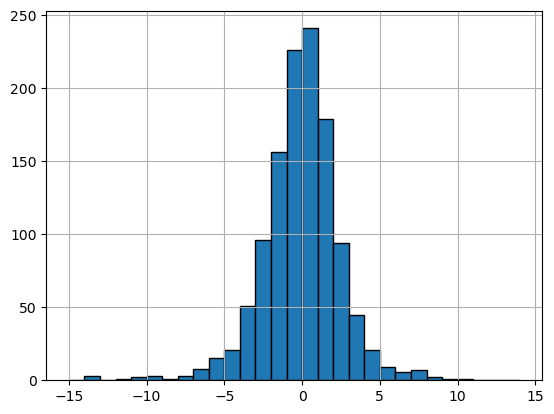

In [34]:
df.change_tomorrow.hist(bins=range(-15,15), edgecolor='black')

And the standard deviation:

In [35]:
df.change_tomorrow.std()

2.859952866189472

We can say that 68% of the changes are between -3.5 and 3.5, approximately.

#### Change sign

Did the stock go up or down?

In [36]:
import numpy as np
print(np.__version__)

1.26.4


In [37]:
df.change_tomorrow = np.where(df.change_tomorrow > 0, 1, -1)
df

,Open,High,Low,Close,Adj Close,Volume,change_tomorrow
Date,,,,,,,
2020-01-02,60.240002,60.970001,60.220001,60.840000,53.666477,18056000,-1
2020-01-03,59.810001,60.700001,59.810001,60.099998,53.013714,15293900,-1
2020-01-06,59.590000,60.200001,59.330002,59.930000,52.863766,17755200,-1
2020-01-07,59.779999,59.799999,58.889999,58.930000,51.981674,21876100,1
2020-01-08,58.889999,59.320000,58.520000,58.970001,52.016953,23133500,1
...,...,...,...,...,...,...,...
2024-09-26,24.280001,24.420000,23.250000,23.920000,23.920000,95416900,-1
2024-09-27,24.160000,24.660000,23.700001,23.910000,23.910000,85883300,-1
2024-09-30,23.740000,23.950001,23.090000,23.459999,23.459999,66308200,-1


## Compute Machine Learning model

Proposal: Random Forest within `ensemble` module of `sklearn` library

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
model = RandomForestClassifier(max_depth=7, random_state=42)

In [40]:
y = df.change_tomorrow
X = df.drop(columns='change_tomorrow')

In [41]:
model.fit(X, y)

RandomForestClassifier(max_depth=7, random_state=42)

In [42]:
model.score(X, y)

0.8235785953177257

## Backtesting

### Create the strategy

In [43]:
class SimpleClassificationUD(Strategy):
    def init(self):
        self.model = model
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[-1:, :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        # conditions to sell or buy
        if forecast_tomorrow == 1 and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow == -1 and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

### Run the Backtest

In [44]:
bt = Backtest(
    X, SimpleClassificationUD, cash=10000,
    commission=.002, exclusive_orders=True
)

In [45]:
results = bt.run()

### Show the report in a DataFrame

In [46]:
results.to_frame('Value').loc[:'Return [%]']

,Value
Start,2020-01-02 00:00:00
End,2024-10-02 00:00:00
Duration,1735 days 00:00:00
Exposure Time [%],99.665552
Equity Final [$],50230003.551704
Equity Peak [$],50230003.551704
Return [%],502200.035517


## Plot the backtest report

> Don't worry about this new tool just yet, we will explain in a future chapter how to interpret the following chart.

In [ ]:
#import backtesting
#print(backtesting.__file__)

In [47]:
bt.plot(filename='reports_backtesting/classification.html')

c:\Users\richa\anaconda3\envs\algo_trading\Lib\site-packages\backtesting\_plotting.py:463: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')


GridPlot(id='p1665', ...)

## How to invest based on the numerical increase?

> Instead of the direction (UP or DOWN)

Next chapter → [Backtesting with Regression Models]()

Classification Model | Regression Model
-|-
![](src/pred_classification.png) | ![](src/pred_regression.png)

Classification Strategy | Regression Strategy
-|-
![](src/res_classification.png) | ![](src/res_regression.png)